In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl_toolkits
from scipy.stats import binned_statistic_2d
from numba import njit
import h5py as h5
import os
from scipy.signal import argrelextrema
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [59]:
name = 'MW4_MHG0.25_GSE6'
nameiso = 'MW4iso_fg0.2_MHG0.25_RC9'
nameN = 'MW3_MHG0.25_GSE2N'

In [67]:
sn = {}
sn_iso = {}
sn_N = {}
num_list = np.arange(0, 800, 50)
print(num_list)
for num in tqdm(num_list):
    sn[num] = arepo.Snapshot(basepath + 'runs/'+name+'/lvl4/output', num, parttype=[0,4],
                             fields = ['Coordinates', 'Velocities', 'Masses',
                                       'GFM_Metallicity', 'GFM_Metals'],
                             combineFiles=True)
    sn_iso[num] = arepo.Snapshot(basepath + 'runs/'+nameiso+'/lvl4/output', num, parttype=[0,4],
                             fields = ['Coordinates', 'Velocities', 'Masses',
                                       'GFM_Metallicity', 'GFM_Metals'],
                                    combineFiles=True)
    sn_N[num] = arepo.Snapshot(basepath + 'runs/'+nameN+'/lvl4/output', num, parttype=[0,4],
                             fields = ['Coordinates', 'Velocities', 'Masses',
                                       'GFM_Metallicity', 'GFM_Metals'],
                                    combineFiles=True)

[  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700 750]


100%|██████████| 16/16 [00:13<00:00,  1.22it/s]


In [61]:
COM_fpath = basepath + 'anlys/COM/COM_' + nameiso + '-lvl4' + '.npy'
COM_iso = np.load(COM_fpath, allow_pickle=True).item()

COM_fpath = basepath + 'anlys/COM/COM_' + name + '-lvl4' + '.npy'
COM = np.load(COM_fpath, allow_pickle=True).item()

COM_fpath = basepath + 'anlys/COM/COM_' + nameN + '-lvl4' + '.npy'
COM_N = np.load(COM_fpath, allow_pickle=True).item()

In [62]:
@njit
def rodrigues_formula(k, v, theta):
    N = v.shape[0]
    v_rot = np.zeros(np.shape(v))
    
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    for i in range(N):
        v_rot[i] = v[i] * ctheta + np.cross(k, v[i]) * stheta + k * (np.dot(k, v[i])) * (1-ctheta)
    
    return v_rot

In [68]:
def get_rot_pos_vel(sni, snap, COM, ptype=0):
    part = getattr(sni, 'part'+str(ptype))
    pos = part.pos.value - COM['MW_COM'][snap]
    vel = part.vel.value - COM['MW_COMV'][snap]

    ang_mom = COM['MW_AngMom'][snap]

    angmom_dir = ang_mom/np.linalg.norm(ang_mom)
    theta = np.arccos(np.dot(angmom_dir, np.array([0, 0, 1])))
    k = np.cross(ang_mom, np.array([0, 0, 1.]))
    k /= np.linalg.norm(k)

    pos_rot = rodrigues_formula(k, pos.astype(np.float64), theta)
    vel_rot = rodrigues_formula(k, vel.astype(np.float64), theta)

    return pos_rot, vel_rot

def sel_SN(pos, Rmin=7, Rmax=9, zcut=3):
    R = np.linalg.norm(pos[:,:2], axis=1)
    z = pos[:,2]
    
    key = np.logical_and(R > Rmin, R < Rmax)
    key = np.logical_and(key, np.abs(z) < zcut)
    
    return key

In [64]:
def get_T_Z(sn, COM):
    Zlist = []
    Tlist = []
    for num in num_list:
    
        pos, vel = get_rot_pos_vel(sn[num], num, COM)
        in_SN = sel_SN(pos, Rmin=12, Rmax=14, zcut=1)

        Z = np.log10(np.mean(sn[num].part0.GFM_Metallicity[in_SN]/0.0127))
        Zlist.append(Z)
        Tlist.append(sn[num].Time.value)

    Tlist = np.array(Tlist)
    Zlist = np.array(Zlist)
    
    return Tlist, Zlist

In [65]:
T, Z = get_T_Z(sn, COM)
Tiso, Ziso = get_T_Z(sn_iso, COM_iso)
TN, ZN = get_T_Z(sn_N, COM_N)

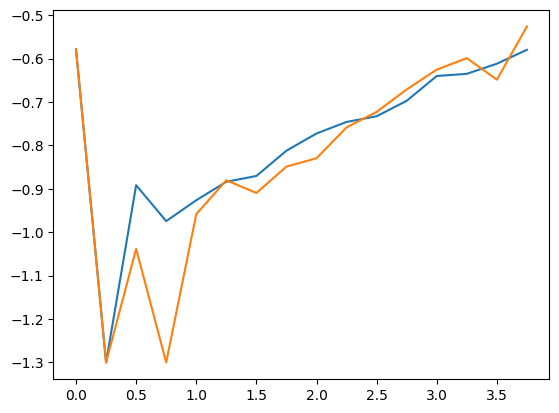

In [66]:
plt.plot(Tiso, Ziso)
plt.plot(T, Z)
# plt.plot(TN, ZN)

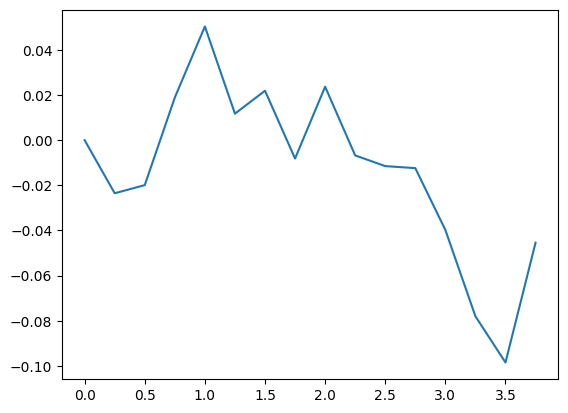

In [40]:
plt.plot(T, Ziso-Z)

In [82]:
num = 750
Rmin = 11
Rmax = 13

pos, vel = get_rot_pos_vel(sn[num], num, COM, ptype=4)
in_SN = sel_SN(pos, Rmin=Rmin, Rmax=Rmax, zcut=1)

Z = np.log10(sn[num].part4.GFM_Metallicity[in_SN]/0.0127)

pos, vel = get_rot_pos_vel(sn_iso[num], num, COM_iso, ptype=4)
in_SN = sel_SN(pos, Rmin=Rmin, Rmax=Rmax, zcut=1)

Ziso = np.log10(sn_iso[num].part4.GFM_Metallicity[in_SN]/0.0127)

-0.6099417
-0.5515921


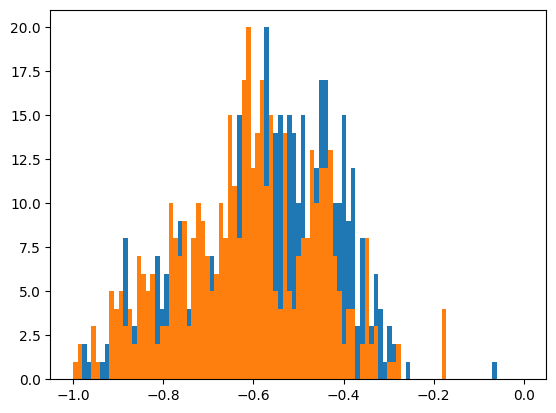

In [83]:
plt.hist(Z, np.linspace(-1, 0, 100));
plt.hist(Ziso, np.linspace(-1, 0, 100));
print(np.median(Ziso))
print(np.median(Z))